In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from notebook_utils import load_data, train, accuracy_multiclass
from notebook_utils import NN
from torchsummary import summary

import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

from torch import nn

In [60]:
n_classes = 2

In [61]:
train_loader, test_data, test_labels = load_data(n_classes=n_classes)

Files already downloaded and verified
Files already downloaded and verified


In [62]:
# class NN(nn.Module):
#     def __init__(self, n_classes):
#         super(NN, self).__init__()
#         quantiles = 3
        
#         n_out = 1 if n_classes == 2 else n_classes
        
#         self.fe = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.BatchNorm2d(16),           
#         )
            
#         self.classifier = nn.Sequential(
#             nn.Linear(3136, n_out),
#         )
        
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         self.to(self.device)
        
#     def forward(self, x):
#         z = self.fe(x)
#         z = z.view(x.shape[0], -1)
#         return self.classifier(z).squeeze(-1)
   


In [63]:
canonical = NN(n_classes=n_classes)
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
print(summary(canonical, input_size=(3, 32, 32)))
train(canonical, optimizer, loss_fn, 
      train_loader, test_data, test_labels, class_weights=[0.5, 0.5])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
         MaxPool2d-7           [-1, 16, 16, 16]               0
           Dropout-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [64]:
canonical.eval()

canonical_state_dict = canonical.fe.state_dict()

In [65]:
overconfident = NN(n_classes=n_classes)
overconfident.eval()

for name, parameter in overconfident.fe.named_parameters():
    weight = canonical_state_dict[name]
    parameter.data = weight
    parameter.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overconfident_weight = torch.Tensor([2]).to(device)
    
optimizer = torch.optim.Adam(overconfident.parameters(), lr=1e-2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
overconfident_weight = [0.4, 0.6]
train(overconfident, optimizer, loss_fn, train_loader, test_data, test_labels, class_weights=overconfident_weight)

Epoch 0 	 Validation loss: 45.34, Train loss: 0.10
Epoch 1 	 Validation loss: 16.46, Train loss: 0.07
Epoch 2 	 Validation loss: 1.17, Train loss: 0.06
Epoch 3 	 Validation loss: 0.14, Train loss: 0.06
Epoch 4 	 Validation loss: 0.06, Train loss: 0.05
Epoch 5 	 Validation loss: 0.05, Train loss: 0.05
Epoch 6 	 Validation loss: 0.04, Train loss: 0.05
Epoch 7 	 Validation loss: 0.04, Train loss: 0.05
Epoch 8 	 Validation loss: 0.04, Train loss: 0.05
Epoch 9 	 Validation loss: 0.04, Train loss: 0.05
Epoch 10 	 Validation loss: 0.04, Train loss: 0.05
Epoch 11 	 Validation loss: 0.04, Train loss: 0.05
Epoch 12 	 Validation loss: 0.04, Train loss: 0.05
Epoch 13 	 Validation loss: 0.04, Train loss: 0.05
Epoch 14 	 Validation loss: 0.04, Train loss: 0.05
Epoch 15 	 Validation loss: 0.04, Train loss: 0.05
Epoch 16 	 Validation loss: 0.04, Train loss: 0.05
Epoch 17 	 Validation loss: 0.04, Train loss: 0.05


In [66]:
for name, parameter in overconfident.fe.named_parameters():
    print(parameter[0][0])
    break

tensor([[-0.0379,  0.0658, -0.0444],
        [-0.2414, -0.1834, -0.0540],
        [-0.1480,  0.1011, -0.0892]])


In [67]:
for name, parameter in canonical.fe.named_parameters():
    print(parameter[0][0])
    break

tensor([[-0.0379,  0.0658, -0.0444],
        [-0.2414, -0.1834, -0.0540],
        [-0.1480,  0.1011, -0.0892]], grad_fn=<SelectBackward>)


In [68]:
underconfident = NN(n_classes=n_classes)
underconfident.eval()

for name, parameter in underconfident.fe.named_parameters():
    weight = canonical_state_dict[name]
    parameter.data = weight
    parameter.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
underconfident_weight = torch.Tensor([2]).to(device)
    
optimizer = torch.optim.Adam(underconfident.parameters(), lr=1e-2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
underconfident_weight = [0.6, 0.4]
train(underconfident, optimizer, loss_fn, train_loader, test_data, test_labels, class_weights=underconfident_weight)

Epoch 0 	 Validation loss: 15.43, Train loss: 0.11
Epoch 1 	 Validation loss: 9.50, Train loss: 0.06
Epoch 2 	 Validation loss: 1.19, Train loss: 0.05
Epoch 3 	 Validation loss: 0.13, Train loss: 0.06
Epoch 4 	 Validation loss: 0.07, Train loss: 0.05
Epoch 5 	 Validation loss: 0.05, Train loss: 0.05
Epoch 6 	 Validation loss: 0.04, Train loss: 0.05
Epoch 7 	 Validation loss: 0.04, Train loss: 0.05
Epoch 8 	 Validation loss: 0.04, Train loss: 0.04
Epoch 9 	 Validation loss: 0.04, Train loss: 0.05
Epoch 10 	 Validation loss: 0.04, Train loss: 0.05
Epoch 11 	 Validation loss: 0.04, Train loss: 0.05
Epoch 12 	 Validation loss: 0.04, Train loss: 0.05
Epoch 13 	 Validation loss: 0.04, Train loss: 0.05
Epoch 14 	 Validation loss: 0.04, Train loss: 0.05
Epoch 15 	 Validation loss: 0.04, Train loss: 0.05
Epoch 16 	 Validation loss: 0.04, Train loss: 0.05
Epoch 17 	 Validation loss: 0.04, Train loss: 0.05
Epoch 18 	 Validation loss: 0.04, Train loss: 0.05
Epoch 19 	 Validation loss: 0.04, Train 

In [69]:
underconfident.eval()
canonical.eval()
overconfident.eval()

NN(
  (fe): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3)
    (16): Conv2d(32, 64, kernel_siz

In [70]:
with torch.no_grad():
    outputs_val = [underconfident(test_data), 
                   canonical(test_data), 
                   overconfident(test_data)]

In [71]:
outputs_val = torch.stack([torch.sigmoid(output) for output in outputs_val], dim=-1)

In [72]:
roc_auc_score(test_labels, outputs_val[:, 1])

0.996012

In [73]:
uncertainties = outputs_val[:, 2] - outputs_val[:, 0]

Text(0, 0.5, 'Uncertainty')

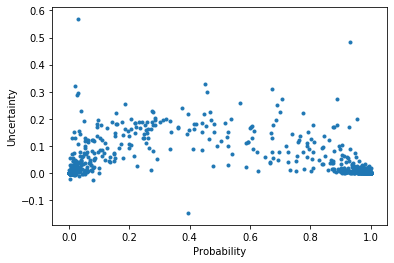

In [74]:
plt.scatter(outputs_val[:, 1], uncertainties, marker='.')
plt.xlabel('Probability')
plt.ylabel('Uncertainty')


In [75]:
outputs_val.shape

torch.Size([2000, 3])

In [76]:
outputs_val[:, 0].mean(), outputs_val[:, 1].mean(), outputs_val[:, 2].mean()

(tensor(0.4943), tensor(0.4933), tensor(0.5113))

In [77]:
test_labels = test_labels.numpy()

In [78]:
cutoff = np.percentile(outputs_val[:, 1], 100 * (1-test_labels.mean()))
cutoff

0.4139768034219742

In [79]:
preds = outputs_val[:, 1] > cutoff

In [80]:
wrong_preds = (preds.numpy() != test_labels)

In [81]:
roc_auc_score(wrong_preds, uncertainties)

0.9336190108759552

In [82]:
average_precision_score(wrong_preds, uncertainties)

0.32629227779118375

In [83]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 1], cutoff)

In [84]:
roc_auc_score(wrong_preds, uncertainties)

0.9384277630805409

In [85]:
average_precision_score(wrong_preds, uncertainties)

0.3400862561692614